# Appendix A: step by step to the generation of the lon-lat surface area array

## Import the packages and read the temperature data

In [1]:
# Define the tools we are going to need today
%matplotlib inline
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xray  # NetCDF library
import cartopy  # Plotting libary
import cartopy.crs as ccrs  # Projections
# Some defaults
plt.rcParams['figure.figsize'] = (14, 5)  # Default plot size
np.set_printoptions(threshold=20)  # avoid to print very large arrays on screen
# The commands below are not important
import warnings
warnings.filterwarnings('ignore')

We will now read the temperature variable as we did last time:

In [2]:
netcdf = xray.open_dataset('ERA-Int-Monthly-2mTemp.nc')
t2_var = netcdf.t2m

## "Real" average temperature of the Earth

As you remember, t2_var is a multidimensional array:

In [3]:
print(t2_var.dims)

('time', 'latitude', 'longitude')


We have learned how to average this 3D array over time:

In [4]:
t2_avg = t2_var.mean(dim='time')
t2_avg

<xray.DataArray 't2m' (latitude: 241, longitude: 480)>
array([[ 257.84742927,  257.84742927,  257.84742927, ...,  257.84742927,
         257.84742927,  257.84742927],
       [ 257.84873041,  257.85052202,  257.85238659, ...,  257.84434462,
         257.84589708,  257.84726713],
       [ 257.96570388,  257.96888176,  257.97208396, ...,  257.95092107,
         257.95588246,  257.96081546],
       ..., 
       [ 228.64890091,  228.63534223,  228.62179977, ...,  228.69163607,
         228.67742885,  228.66307165],
       [ 228.35621998,  228.34951968,  228.34279101, ...,  228.36645891,
         228.36303377,  228.35967754],
       [ 227.47810828,  227.47810828,  227.47810828, ...,  227.47810828,
         227.47810828,  227.47810828]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...

or how to compute the total average:

In [5]:
print(t2_avg.mean())

<xray.DataArray 't2m' ()>
array(278.4124133235189)


Which, as we have discussed in exercise 01, is definitely **not** the average temperature of the Earth. We are now computing a "weight grid" in order to take into account that the Earth is round. This quite cumbersome (but necessary) task will help us to learn a bit more about DataArrays and python.

### Create our own DataArray to do a weighted average

First we have to define our objective: **creating a ``area`` array with dimensions ``('latitude', 'longitude')`` representing the surface area of the grid point.** Let's begin by noting that the area of a [spherical segment](https://en.wikipedia.org/wiki/Spherical_segment) between the latitudes $\varphi_1$ and $\varphi_2$ is:

$$A_S = 2 \pi R^2 \left| \sin \varphi_2 - \sin \varphi_1 \right| $$

With R being the radius of the Earth (6371 km).

### Area of spherical segments 

OK. So now we are going to compute the latitudes $\varphi_1$ and $\varphi_2$, which are located *in between* our data coordinates. Our latitude coordinates are:

In [6]:
t2_avg.latitude

<xray.DataArray 'latitude' (latitude: 241)>
array([ 90.  ,  89.25,  88.5 , ..., -88.5 , -89.25, -90.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 84.75 ...
Attributes:
    units: degrees_north
    long_name: latitude

But these are located in the *center* of the grid points. We need the border of those grid points: [90., 89.625, 88.875], etc. There are several ways to do this, I use the following method. First, I will use the function [np.arange](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.arange.html) in order to make an increasing array of 242 elements (as long as the latitude array + 1 element. Yes, to compute the area of **one** spherical segment, one needs **two** latitude values):

In [7]:
corner_lats = np.arange(242)
corner_lats

array([  0,   1,   2, ..., 239, 240, 241])

Then I convert it to latitudes:

In [8]:
corner_lats = corner_lats * 0.75 - 90.375
corner_lats

array([-90.375, -89.625, -88.875, ...,  88.875,  89.625,  90.375])

Ok, this looks good up to the poles, where the grid points should actually be half ones. For these two I will simply use the [np.clip](http://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html) function:

In [9]:
corner_lats = np.clip(corner_lats, -90, 90)
corner_lats

array([-90.   , -89.625, -88.875, ...,  88.875,  89.625,  90.   ])

Perfect! Now I can compute the area of the spherical segment for each of my latitudes. But first, I won't forget to convert my latitudes from degrees to radians (trigonometry does not know about "degrees"):

In [10]:
corner_lats_deg = np.deg2rad(corner_lats)

In [11]:
area_segment = 2 * np.pi * 6371**2 * np.abs(np.sin(corner_lats_deg[1:]) - np.sin(corner_lats_deg[:-1]))

OK, I admit, these are a lot of new commands at one time. "``np.pi``", "``np.abs``", and "``np.sin``" are self-explaining (or easily googled). "``**2``" is like Matlab's "``.^2``". Maybe a little less intuitive is the last part of the equation. What did I do?

**E: try it out! print the value of ``corner_lats[1:]`` and corner_lats[:-1]. What is the length of our new array ``area_segment``?** (hint: python built-in function ``len()``)

In [12]:
# You're answer here

**Q: can you think of an easy test to see if our computed segments are right?**

In [13]:
# You're answer here

### Back to the sphere 

Now we have an array of 241 elements, each element being the area of a spherical segment on the sphere. We still need a bit of work to get to our 2D array of dimensions (241, 480). To do this there are dozens of possibilities and I struggled to pick the easiest to explain. I chose to use xray to help us out. As you have noticed, xray is "dimensions aware". This simply means that once we have defined the dimension and coordinates of a DataArray, xray knows what to do with it. 

First we will create an new DataArray of dimenstions (241, 480) full with ones. This is most easily done with a simple trick:  

In [14]:
area_grid = t2_avg * 0 + 1
area_grid

<xray.DataArray 't2m' (latitude: 241, longitude: 480)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...

We are now telling xray that our array ``area_segment`` has the same latitude coordinates as our temperature array:

In [15]:
area_segment_xray = 
area_segment_xray

<xray.DataArray (latitude: 241)>
array([  5462.36608756,  43697.52477304,  87387.56220012, ...,
        87387.56220012,  43697.52477304,   5462.36608756])
Coordinates:
  * latitude  (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 84.75 ...

When we multiply the two, xray knows what to do:

In [16]:
area_grid = area_grid * area_segment_xray

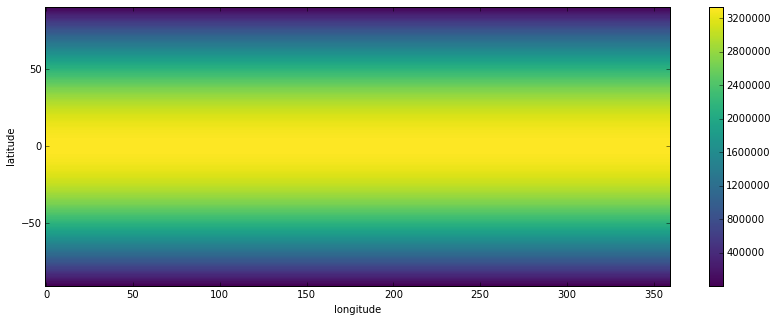

In [17]:
area_grid.plot();

OK! Now a last important detail: each pixel contains the area of an *entire* spherical segment! We simply have to divide this value by the number of longitude points to get the result we are looking for:

In [18]:
area_grid = area_grid / 480

### Final test

To see if everything went well, we simply need to check that the sum of our pixels is indeed equal to the area of the Earth:

In [19]:
print("Our area: ", area_grid.sum().values)
print("Earth area: ", 4 * np.pi * 6371**2)

Our area:  510064471.9097883
Earth area:  510064471.90978825
